In [1]:
import pandas as pd
churnData = pd.read_csv('DATA_Customer-Churn.csv')
churnData.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,Yes,No,No,No,No,Month-to-month,29.85,29.85,No
1,Male,0,No,No,34,Yes,Yes,No,Yes,No,No,No,One year,56.95,1889.5,No
2,Male,0,No,No,2,Yes,Yes,Yes,No,No,No,No,Month-to-month,53.85,108.15,Yes
3,Male,0,No,No,45,No,Yes,No,Yes,Yes,No,No,One year,42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,No,No,No,No,No,Month-to-month,70.70,151.65,Yes


In [2]:
churnData.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [3]:
churnData['TotalCharges'] = pd.to_numeric(churnData['TotalCharges'], errors='coerce')
churnData['Churn'] = churnData['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
print(churnData['Churn'].value_counts())

0    5174
1    1869
Name: Churn, dtype: int64


In [4]:
churnData.isna().sum()
churnData = churnData.dropna()

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

log_model = LogisticRegression() 

## Data splitting
features = churnData[['tenure', 'SeniorCitizen', 'MonthlyCharges', 'TotalCharges']]
target = churnData['Churn']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

pt = PowerTransformer()
pt.fit(X_train)
X_train_log = pt.transform(X_train)
X_test_log = pt.transform(X_test)

#where the magic happens

log_model.fit(X_train_log, y_train)

y_pred_train_log = log_model.predict(X_train_log)
y_pred_test_log = log_model.predict(X_test_log)

performance_log = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_pred_train_log),
                                         precision_score(y_train, y_pred_train_log),
                                         recall_score(y_train, y_pred_train_log)],
                               'Test': [accuracy_score(y_test, y_pred_test_log),
                                        precision_score(y_test, y_pred_test_log),
                                        recall_score(y_test, y_pred_test_log)]})

display(performance_log)



,Error_metric,Train,Test
0,Accuracy,0.795378,0.781805
1,Precision,0.667641,0.630350
2,Recall,0.458194,0.433155


In [6]:
print(churnData['Churn'].value_counts())


0    5163
1    1869
Name: Churn, dtype: int64


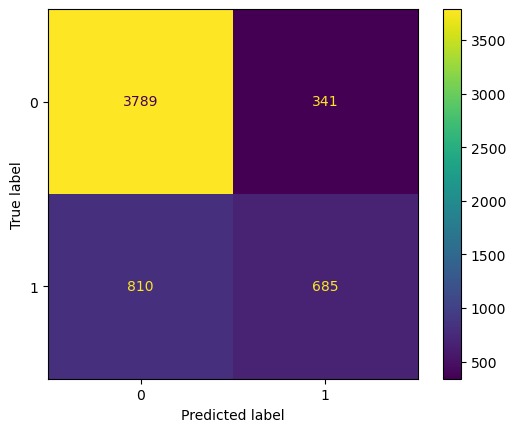

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_train = confusion_matrix(y_train, y_pred_train_log, labels = log_model.classes_)
disp = ConfusionMatrixDisplay(cm_train)
disp.plot()

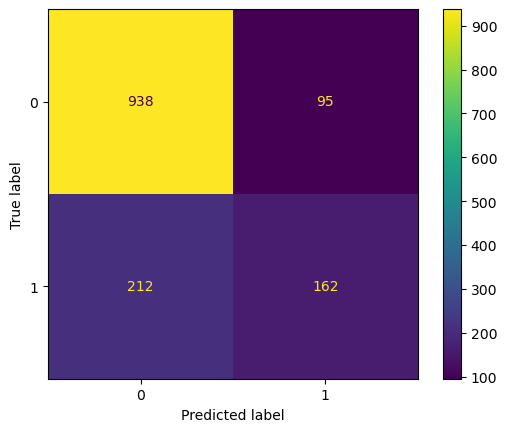

In [8]:
cm_test = confusion_matrix(y_test, y_pred_test_log, labels = log_model.classes_)
disp_test = ConfusionMatrixDisplay(cm_test)
disp_test.plot()

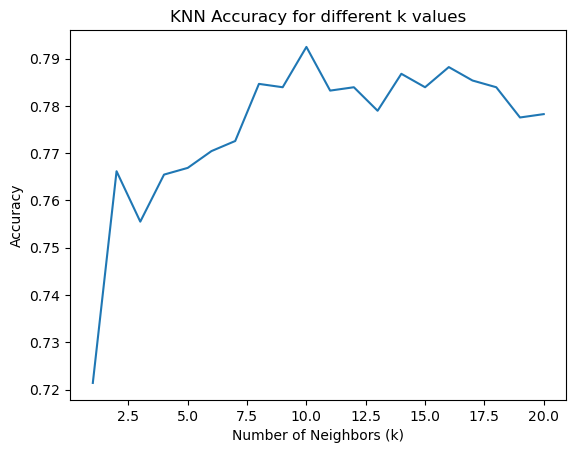

Best k value: 10


In [9]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

# list to store the results
results = []

# loop through different values of k
for k in range(1, 21):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train_log, y_train)
    y_pred_test_knn = knn_model.predict(X_test_log)
    accuracy = accuracy_score(y_test, y_pred_test_knn)
    results.append(accuracy)

# plot the results
plt.plot(range(1, 21), results)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy for different k values')
plt.show()

best_k = results.index(max(results)) + 1

print("Best k value:", best_k)

In [10]:
knn_model = KNeighborsClassifier(n_neighbors=10)
knn_model.fit(X_train_log, y_train)

y_pred_train_knn = knn_model.predict(X_train_log)
y_pred_test_knn = knn_model.predict(X_test_log)

def print_model_analysis(true, pred):
    print('Accuracy:', accuracy_score(true, pred))
    print('Precision:', precision_score(true, pred))
    print('Recall:', recall_score(true, pred))
    print('Confusion Matrix:')
    print(confusion_matrix(true, pred))

print_model_analysis(y_test, y_pred_test_knn)


Accuracy: 0.7924662402274343
Precision: 0.6680327868852459
Recall: 0.4358288770053476
Confusion Matrix:
[[952  81]
 [211 163]]


In [11]:
# Importing necessary libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up a random seed for reproducibility
RANDOM_SEED = 42

# ROUND 2

# 1. Fit a Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=RANDOM_SEED)
dt_model.fit(X_train_log, y_train)

# 2. Check the accuracy on the test data
y_pred_dt = dt_model.predict(X_test_log)
print("Decision Tree Test Accuracy:", accuracy_score(y_test, y_pred_dt))

# ROUND 3

# 1. Apply K-fold cross validation on your models (Logistic, KNN, Decision Tree)
models = [log_model, knn_model, dt_model]
model_names = ['Logistic Regression', 'KNN', 'Decision Tree']

for model, name in zip(models, model_names):
    scores = cross_val_score(model, features, target, cv=10, scoring="accuracy")
    print(f"{name} average accuracy after K-fold CV: {scores.mean()}")

# ROUND 4

# 1. Fit a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=RANDOM_SEED)
rf_model.fit(X_train_log, y_train)

# Check the accuracy
y_pred_rf = rf_model.predict(X_test_log)
print("Random Forest Test Accuracy:", accuracy_score(y_test, y_pred_rf))

# 2. Tune the hyperparameters with GridSearch
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train_log, y_train)

# Display the best parameters from the grid search
print("Best parameters from GridSearch:", grid_search.best_params_)
print("Best accuracy from GridSearch:", grid_search.best_score_)

# Managing imbalance in the dataset

# 1. Check for the imbalance
print(churnData['Churn'].value_counts())

# 2. Resampling strategies: Here, I'm demonstrating both upsampling and downsampling

# Upsampling
minority = churnData[churnData['Churn'] == 1]
majority = churnData[churnData['Churn'] == 0]

minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=RANDOM_SEED)
upsampled = pd.concat([majority, minority_upsampled])

# Downsampling
majority_downsampled = resample(majority, replace=False, n_samples=len(minority), random_state=RANDOM_SEED)
downsampled = pd.concat([minority, majority_downsampled])

# 3. Fit the model for both upsampled and downsampled data and check accuracy

# Here, I'm demonstrating for RandomForest but it can be applied to other models as well

# For upsampled
X_up = upsampled[['tenure', 'SeniorCitizen', 'MonthlyCharges', 'TotalCharges']]
y_up = upsampled['Churn']
X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(X_up, y_up, test_size=0.2, random_state=RANDOM_SEED)

# Transform the data
X_train_up_log = pt.transform(X_train_up)
X_test_up_log = pt.transform(X_test_up)

rf_model.fit(X_train_up_log, y_train_up)
y_pred_up = rf_model.predict(X_test_up_log)
print("Random Forest Accuracy on Upsampled Data:", accuracy_score(y_test_up, y_pred_up))

# For downsampled
X_down = downsampled[['tenure', 'SeniorCitizen', 'MonthlyCharges', 'TotalCharges']]
y_down = downsampled['Churn']
X_train_down, X_test_down, y_train_down, y_test_down = train_test_split(X_down, y_down, test_size=0.2, random_state=RANDOM_SEED)

# Transform the data
X_train_down_log = pt.transform(X_train_down)
X_test_down_log = pt.transform(X_test_down)

rf_model.fit(X_train_down_log, y_train_down)
y_pred_down = rf_model.predict(X_test_down_log)
print("Random Forest Accuracy on Downsampled Data:", accuracy_score(y_test_down, y_pred_down))


Decision Tree Test Accuracy: 0.7249466950959488
Logistic Regression average accuracy after K-fold CV: 0.7915231394672184
KNN average accuracy after K-fold CV: 0.7855525830854779
Decision Tree average accuracy after K-fold CV: 0.7165807254623043
Random Forest Test Accuracy: 0.757640369580668
Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best parameters from GridSearch: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Best accuracy from GridSearch: 0.7893333333333333
0    5163
1    1869
Name: Churn, dtype: int64
Random Forest Accuracy on Upsampled Data: 0.8867376573088093
Random Forest Accuracy on Downsampled Data: 0.7232620320855615
